# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [6]:
%%capture
!pip install rdkit-pypi
!pip install dgllife
!pip install --pre dgl-cu113 dglgo -f https://data.dgl.ai/wheels-test/repo.html

# Import Library

In [7]:
import os
import dgl 
import sys
import random
import torch
import cv2
import torchvision
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from dgllife.model import MLPPredictor
from tensorflow.keras.callbacks import  History
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from Utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator, up_and_down_Samplenig
from Utils.gcnpretrained import get_tox21_model
from Models.heterogeneous_siamese_tox21 import siamese_model_attentiveFp_tox21, siamese_model_Canonical_tox21

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [8]:
cache_path='./tox21_dglgraph.bin'

df = get_dataset("tox21")
id = df['mol_id']
df = df.drop(columns=['mol_id'])

C:\Users\stdso\.dgl/tox21.csv.gz: 123kB [00:00, 409kB/s] 


In [9]:
tox21_tasks = df.columns.values[:12].tolist()

In [10]:
one = []
zero = []
nan = []
 
for task in tox21_tasks:
    a = list(df[task].value_counts(dropna=False).to_dict().values())
    zero.append(a[0])
    nan.append(a[1])
    one.append(a[2])
    print(task ,"one:" ,a[2] ," zero:", a[0], " NAN:",a[1])


NR-AR one: 309  zero: 6956  NAN: 566
NR-AR-LBD one: 237  zero: 6521  NAN: 1073
NR-AhR one: 768  zero: 5781  NAN: 1282
NR-Aromatase one: 300  zero: 5521  NAN: 2010
NR-ER one: 793  zero: 5400  NAN: 1638
NR-ER-LBD one: 350  zero: 6605  NAN: 876
NR-PPAR-gamma one: 186  zero: 6264  NAN: 1381
SR-ARE one: 942  zero: 4890  NAN: 1999
SR-ATAD5 one: 264  zero: 6808  NAN: 759
SR-HSE one: 372  zero: 6095  NAN: 1364
SR-MMP one: 918  zero: 4892  NAN: 2021
SR-p53 one: 423  zero: 6351  NAN: 1057


In [11]:
sum(one), sum(zero)

(5862, 72084)

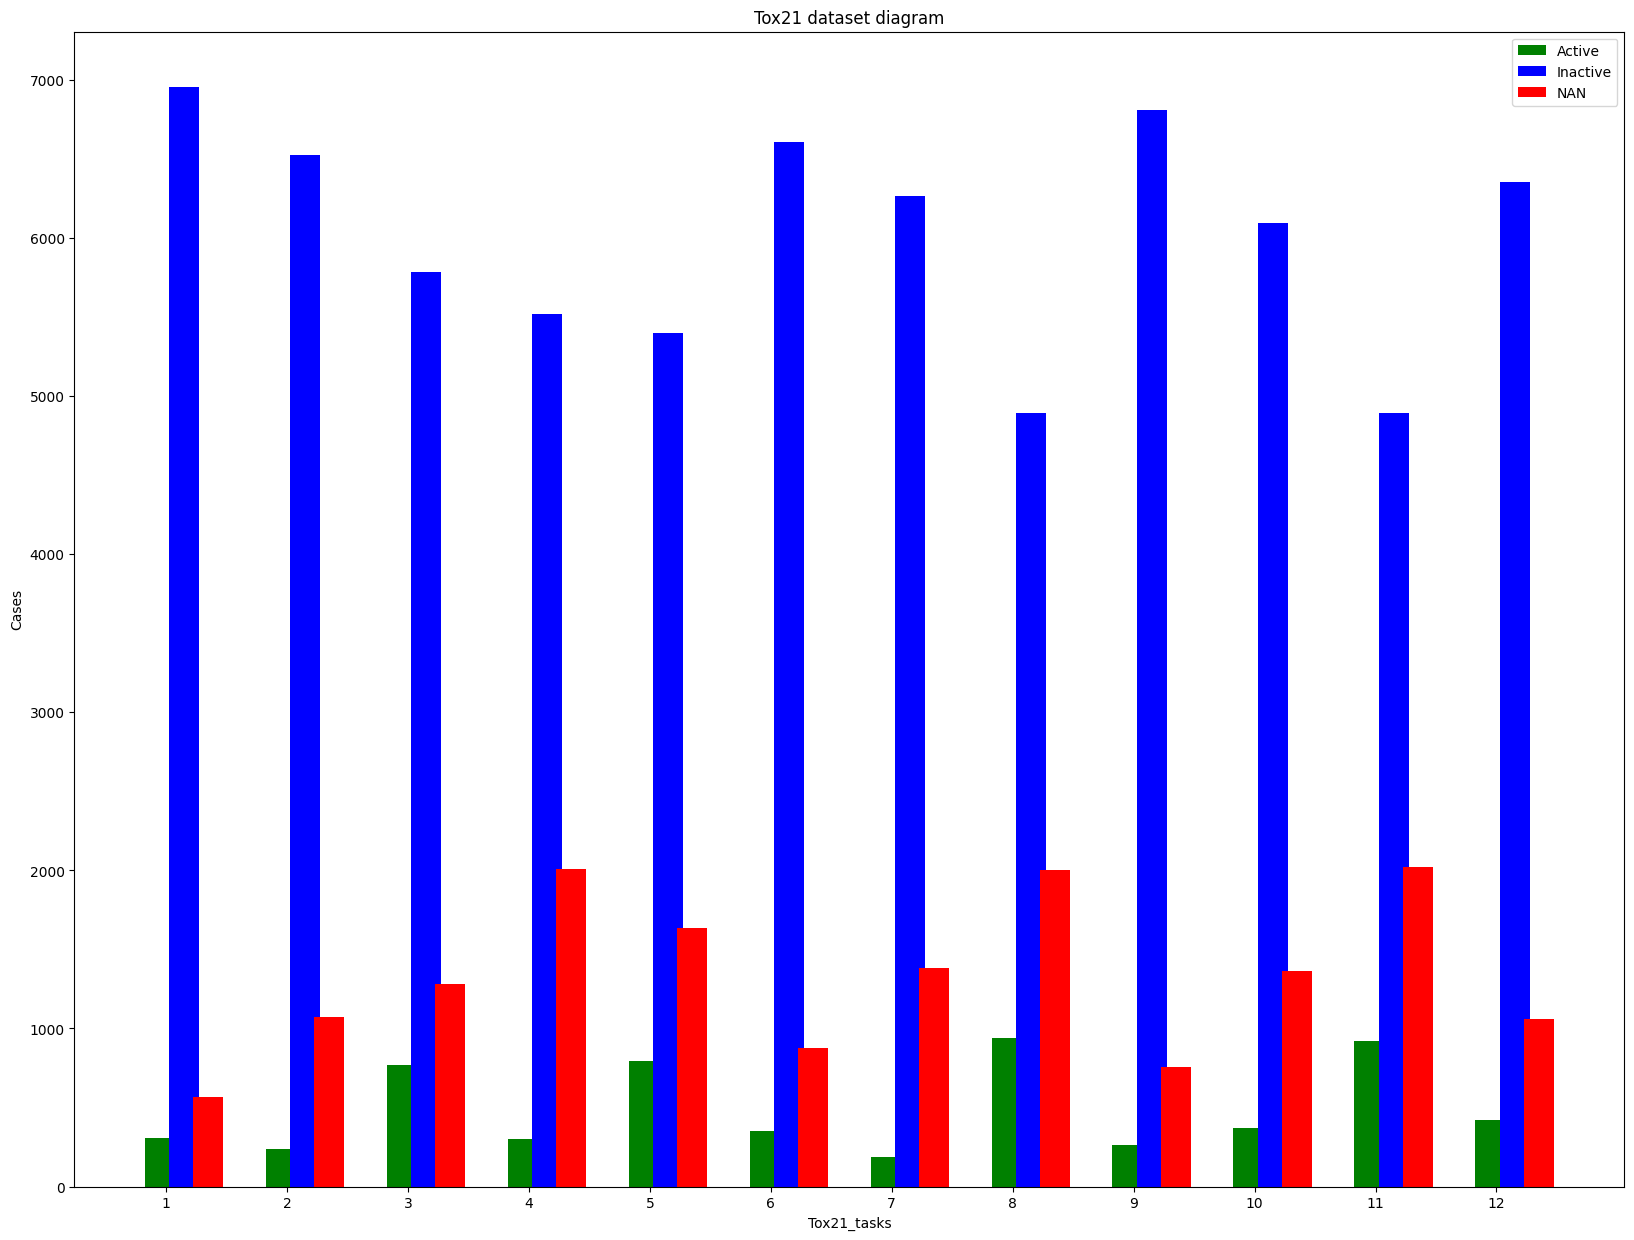

In [12]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])

X = np.arange(1,len(tox21_tasks)+1)
plt.bar(X + 0.2, one, color = 'g', width = 0.25)
plt.bar(X + 0.4, zero, color = 'b', width = 0.25)
plt.bar(X + 0.6, nan, color = 'r', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Active' , 'Inactive' ,'NAN'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,13)], X)
# Giving the tilte for the plot
plt.title("Tox21 dataset diagram")
# Namimg the x and y axis
plt.xlabel('Tox21_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [13]:
from dgllife.model import MLPPredictor

def create_dataset_with_gcn(dataset, class_embed_vector, GCN, tasks, numberTask):

    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)

    for i, data in enumerate(dataset):
        smiles, g, label, mask = data
        g = g.to(device)
        g = dgl.add_self_loop(g)
        graph_feats = g.ndata.pop('h')
        embbed = GCN(g, graph_feats)
        embbed = embbed.to('cpu')
        embbed = embbed.detach().numpy()
        a = ( embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label, numberTask, tasks[numberTask])
        created_data.append(a)
    print('Data created!!')
    return created_data

# Calculation of embedded vectors for each class

In [14]:
df_positive, df_negative = separate_active_and_inactive_data(df, tox21_tasks)

for i,d in enumerate(zip(df_positive,df_negative)):
    print(f'{tox21_tasks[i]}=> positive: {len(d[0])} - negative: {len(d[1])}')

NR-AR=> positive: 309 - negative: 6956
NR-AR-LBD=> positive: 237 - negative: 6521
NR-AhR=> positive: 768 - negative: 5781
NR-Aromatase=> positive: 300 - negative: 5521
NR-ER=> positive: 793 - negative: 5400
NR-ER-LBD=> positive: 350 - negative: 6605
NR-PPAR-gamma=> positive: 186 - negative: 6264
SR-ARE=> positive: 942 - negative: 4890
SR-ATAD5=> positive: 264 - negative: 6808
SR-HSE=> positive: 372 - negative: 6095
SR-MMP=> positive: 918 - negative: 4892
SR-p53=> positive: 423 - negative: 6351


In [15]:
dataset_positive = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_positive]
dataset_negative = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_negative]

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/6956
Processing molecule 2000/6956
Processing molecule 3000/6956
Processing molecule 4000/6956
Processing molecule 5000/6956
Processing molecule 6000/6956
Processing dgl graphs from scratch...
Processing molecule 1000/6521
Processing molecule 2000/6521
Processing molecule 3000/6521
Processing molecule 4000/6521
Processing molecule 5000/6521
Processing molecule 6000/6521
Processing dgl graphs from scratch...
Processing molecule 1000/5781
Processing molecule 2000/5781
Processing

In [16]:
embed_class_tox21 = get_embedding_vector_class(dataset_positive, dataset_negative, radius=2, size = 512)

class vector created!!


# Classification with BioAct-Het and AttentiveFp GCN

In [17]:
model_name = 'GCN_attentivefp_Tox21'
gcn_model = get_tox21_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

GCN_attentivefp_Tox21_pre_trained.pth: 100%|██████████| 1.95M/1.95M [00:00<00:00, 2.11MB/s]

Pretrained model loaded


In [18]:
data_ds = []
for i, task in  enumerate(tox21_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)
    data = create_dataset_with_gcn(ds, embed_class_tox21, gcn_model, tox21_tasks, i)
    for d in data:
        data_ds.append(d)

Processing dgl graphs from scratch...
Processing molecule 1000/7265
Processing molecule 2000/7265
Processing molecule 3000/7265
Processing molecule 4000/7265
Processing molecule 5000/7265
Processing molecule 6000/7265
Processing molecule 7000/7265
Data created!!
Processing dgl graphs from scratch...
Processing molecule 1000/6758
Processing molecule 2000/6758
Processing molecule 3000/6758
Processing molecule 4000/6758
Processing molecule 5000/6758
Processing molecule 6000/6758
Data created!!
Processing dgl graphs from scratch...
Processing molecule 1000/6549
Processing molecule 2000/6549
Processing molecule 3000/6549
Processing molecule 4000/6549
Processing molecule 5000/6549
Processing molecule 6000/6549
Data created!!
Processing dgl graphs from scratch...
Processing molecule 1000/5821
Processing molecule 2000/5821
Processing molecule 3000/5821
Processing molecule 4000/5821
Processing molecule 5000/5821
Data created!!
Processing dgl graphs from scratch...
Processing molecule 1000/6193


In [24]:
print(data_ds)

KeyboardInterrupt: 

In [23]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False):
    
    result =[] 
    s = 0


    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train_ds = [df[index] for index in train_index] 
        print(train_ds)
        
        valid_ds = [df[index] for index in test_index]
        
        label_pos , label_neg, _ , _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, scale_downsampling = 0.5)
        
        label_pos , label_neg , _ , _ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _ , _ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_number, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_number, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,512,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,512,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_attentiveFp_tox21()
        
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100) == Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid], lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
        
        if score[4] > s :
            best_model = siamese_net
            s = score[4]
            print("Save_model!!")
    
    return result , best_model


scores, best_model = evaluate_model(data_ds, 10, True)

KeyboardInterrupt: 

#### Dropout = 0.3 and downsampling = 0.5

In [ ]:
scores

In [ ]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

#### Dropout = 0.2 and downsampling = 0.5 

In [ ]:
scores

In [ ]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

# Classification with BioAct-Het and Canonical GCN 

In [ ]:
model_GCN = 'GCN_canonical_Tox21'
gcn_model = get_tox21_model(model_GCN)
gcn_model.eval()
gcn_model = gcn_model.to(device)

In [ ]:
data_ds = []
for i, task in  enumerate(tox21_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds =  DATASET(a, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)
    data = create_dataset_with_gcn(ds, embed_class_tox21, gcn_model, tox21_tasks, i)
    for d in data:
        data_ds.append(d)

In [ ]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train_ds = [df[index] for index in train_index] 
        
        valid_ds = [df[index] for index in test_index]
        
        label_pos , label_neg, _, _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, scale_downsampling = 0.5)
        
        label_pos , label_neg , _,_ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _,_ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,128,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,128,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_Canonical_tox21()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100) == Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid], lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result

scores = evaluate_model(data_ds, 10, True)

#### Dropout = 0.3 and downsampling = 0.5 

In [ ]:
scores

In [ ]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

#### Dropout = 0.2 and downsampling = 0.5  

In [ ]:
scores

In [ ]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')